# A/B Tests

## Import

### Import raw data test data (X)

In [37]:
def import_data_from_json():
    import pandas as pd
    # Assuming the file path is accessible in your environment
    file_path = '/Users/patricksweeney/growth/01_Acquisition/07_Growth experimentation/AB tests.json'
    # Read the JSON file
    data = pd.read_json(file_path)
    # Convert the first few rows of the DataFrame to JSON
    return data

data = import_data_from_json()
data.head()


,suggested_highlights,channels_disable_new_data_workflow,paginated_user_table,channels_disable_reclustering_workflow,channels_simplification,highlight_embed_atlassian,grab_handles_in_notes,intercom_integration,stripe_product_override,fast_batch_import,...,auto_transcribe_imports,track_with_anonymous_user,dynamic_home,rotate_old_refresh_tokens,ml_summarization_via_bedrock,highlights_without_tags,channels_activity_dialog,enhanced_transcript_summaries,published_insights_in_folders,create_folder_with_permissions
0,0,0,0,0,0,1,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,1,0,0,1,1
1,0,0,0,0,0,1,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,1,0,0,1,1
2,0,0,0,0,0,1,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,1,0,0,1,1
3,0,0,0,0,0,1,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,1,0,0,1,1
4,0,0,0,0,0,1,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,1,0,0,1,1


### Import customer data and outcomes (Y)

In [38]:
def import_data():
    import pandas as pd
    file_path = '/Users/patricksweeney/growth/01_Acquisition/07_Growth experimentation/Customer outcomes.xlsx'
    data = pd.read_excel(file_path)
    return data

customer_data = import_data()
customer_data.head()

/Users/patricksweeney/anaconda3/envs/EconML/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,workspace_id,workspace_created_at,converted_date,mrr_latest,converted,converted_big
0,9e6a8060-18a0-4bf2-8849-974acdb1a405,2024-02-06 16:17:03.745,2024-02-06,48.0,1,0
1,095b76a0-f98b-438c-95f8-267d607d506d,2024-02-05 16:39:28.921,2024-02-05,25.0,1,0
2,1d0c18fa-e839-4074-86c0-0dc80801b75b,2024-02-10 08:13:54.936,NaT,NaN,0,0
3,4b269e54-4468-4bb3-8e60-4361805eecb4,2024-02-07 08:33:00.126,NaT,NaN,0,0
4,58a5a68b-7709-4d86-90c6-04124baddaa8,2024-02-06 16:53:00.576,NaT,NaN,0,0


## Data wrangling

### Find actions that vary

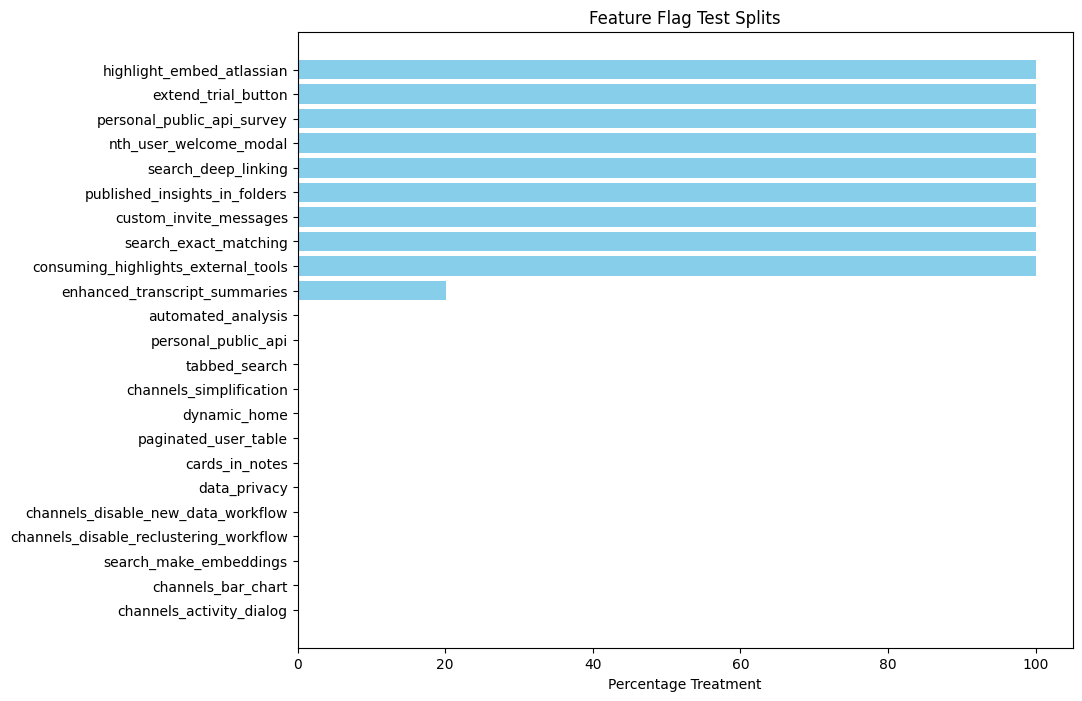

In [39]:
def plot_binary_splits(data):
    import pandas as pd
    import matplotlib.pyplot as plt
    
    # Container for binary column names and their percentage of 1s
    binary_columns = {}

    # Iterate over each column in the DataFrame
    for column in data.columns:
        # Ensure the column has more than one unique value to consider it for analysis
        if data[column].nunique() > 1:
            # Check if the column is binary by considering only non-null values
            unique_values = data[column].dropna().unique()
            if sorted(unique_values) == [0, 1]:
                # Calculate the percentage of 1s
                perc_1 = (data[column].value_counts(normalize=True, dropna=True) * 100).get(1, 0)
                # Store the percentage of 1s in the dictionary
                binary_columns[column] = perc_1
    
    # Proceed only if there are binary columns
    if binary_columns:
        # Sort the binary columns by the percentage of 1s in descending order
        sorted_binary_columns = sorted(binary_columns.items(), key=lambda x: x[1], reverse=True)
        
        # Separate the column names and their percentages for plotting
        columns, percentages = zip(*sorted_binary_columns)
        
        # Creating the bar plot
        plt.figure(figsize=(10, 8))
        plt.barh(columns, percentages, color='skyblue')
        plt.xlabel('Percentage Treatment')
        plt.title('Feature Flag Test Splits')
        plt.gca().invert_yaxis()  # Invert y-axis to have the highest percentage at the top
        plt.show()
    else:
        print("No binary columns found or all binary columns have only one unique value.")

# Assuming 'data' is your pandas DataFrame
plot_binary_splits(data)


### Join on outcomes

In [44]:
def join_on_outcomes(data, customer_data):
    import pandas as pd

    # Perform an inner join on the specified columns
    result = pd.merge(data, customer_data, left_on='context_group_id', right_on='workspace_id', how='inner')

    return result

# Assuming 'data' and 'customer_data' are your pandas DataFrames
joined_data = join_on_outcomes(data, customer_data)
joined_data.head()
print(joined_data.shape)


(1058, 66)


### Check user uniformity over time

## Control variables

To be fair, we need to have control and treatment have
- Same time
- Uniform user assignment over time
- Uniform workspace assignment over time

In [43]:
def controllable_data(joined_data, treatments, conversion_variable='converted'):
    import pandas as pd
    
    # Ensure both 'timestamp' and 'workspace_created_at' are datetime and tz-naive
    joined_data['timestamp'] = pd.to_datetime(joined_data['timestamp']).dt.tz_localize(None)
    joined_data['workspace_created_at'] = pd.to_datetime(joined_data['workspace_created_at']).dt.tz_localize(None)
    
    # Calculate the difference in days
    joined_data['days_since_creation'] = (joined_data['timestamp'] - joined_data['workspace_created_at']).dt.days
    
    # Filter for first 14 days
    filtered_data = joined_data[joined_data['days_since_creation'] <= 7]
    
    controllable_data = pd.DataFrame()  # Initialize an empty DataFrame
    
    # Check uniformity for each workspace_id
    for workspace_id, group in filtered_data.groupby('workspace_id'):
        is_controllable = True  # Assume true until proven otherwise
        for treatment in treatments:
            if group[treatment].nunique() > 1:
                is_controllable = False
                break
        if is_controllable:
            controllable_data = pd.concat([controllable_data, group], ignore_index=True)
    
    # Drop the 'days_since_creation' column as it's no longer needed
    controllable_data.drop(columns=['days_since_creation'], inplace=True)
    
    # Identify binary variables to remove, keeping treatments and the conversion variable
    binary_columns = [col for col in controllable_data.columns if controllable_data[col].dropna().isin([0, 1]).all() 
                      and col not in treatments and col != conversion_variable]
    
    # Remove identified binary columns from the DataFrame
    controllable_data.drop(columns=binary_columns, inplace=True)
    
    return controllable_data

# Assuming 'joined_data' is your DataFrame containing necessary columns including 'workspace_id', 'timestamp', 'workspace_created_at', treatments, and a conversion variable.
treatments = ['enhanced_transcript_summaries']
conversion_variable = 'converted'  # Example conversion variable

# Call the function with the DataFrame, treatment list, and conversion variable.
controllable_df = controllable_data(joined_data, treatments, conversion_variable=conversion_variable)
controllable_df.head()
print(controllable_df.shape)

(1026, 12)


## Calculate uplift

### Calculate x and n

In [47]:
def calculate_x_and_n(controllable_df, conversion_variable, treatment_variable):
    import pandas as pd

    # Group the data by the treatment variable
    grouped = controllable_df.groupby(treatment_variable)
    
    # Calculate the number of distinct workspace_ids
    n_workspaces = grouped['workspace_id'].nunique()
    
    # Calculate the sum of the conversion variable
    sum_conversion = grouped[conversion_variable].sum()
    
    # Combine the results into a DataFrame
    results = pd.DataFrame({
        'N_Workspaces': n_workspaces,
        'Sum_Conversion': sum_conversion
    }).reset_index()

    return results

# Example usage:
# Assuming 'controllable_df' is your DataFrame, 'conversion' is your conversion variable,
# and you have a treatment variable named for example 'deadvertise_team_plan'
conversion_variable = 'converted'  # Replace with your actual conversion variable name
treatment_variable = 'enhanced_transcript_summaries'  # Replace with your actual treatment variable name

# Call the function with the DataFrame, conversion variable, and treatment variable.
results_df = calculate_x_and_n(controllable_df, conversion_variable, treatment_variable)

# Display the results
print(results_df)


   enhanced_transcript_summaries  N_Workspaces  Sum_Conversion
0                              0           810               2
1                              1           201               0


### Calculate ATE and Cohen's d

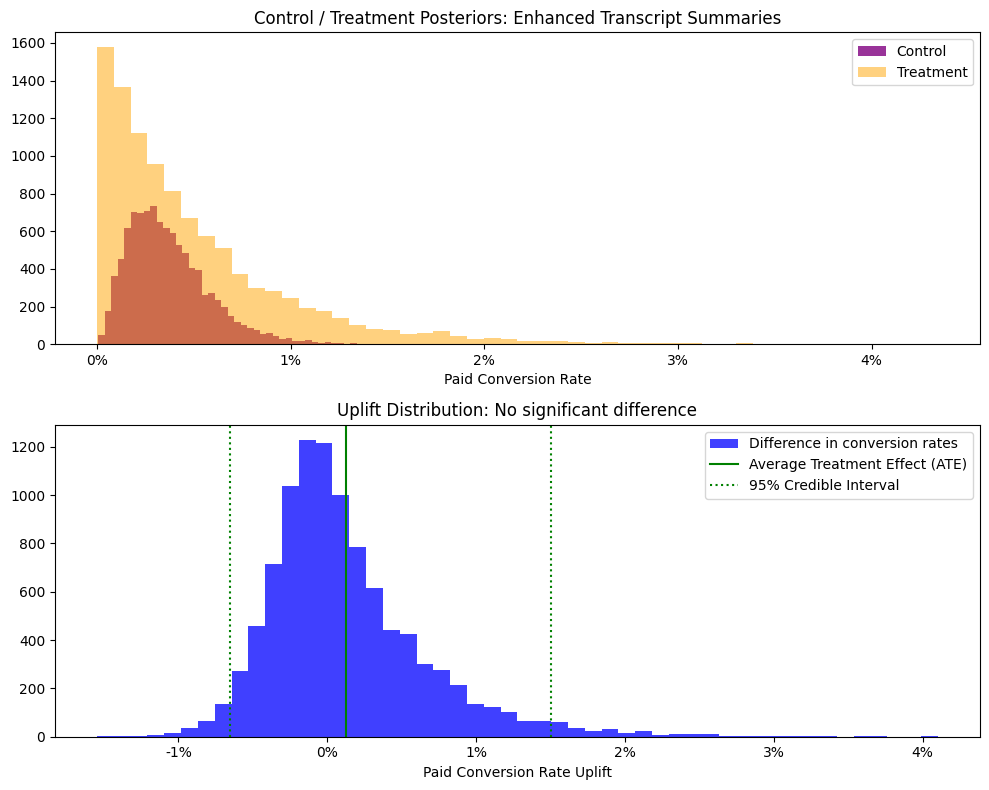

Estimated difference in conversion rates: 0.12%
95% credible interval for the difference: [-0.65%, 1.50%]


In [71]:
import matplotlib.pyplot as plt
import numpy as np

# Observed data
x_c, n_c = 2, 810  # Control group: 2 conversions out of 810 trials
x_t, n_t = 0, 201  # Treatment group: 0 conversions out of 201 trials

# Generate posterior samples
samples_p_c = np.random.beta(1 + x_c, 1 + n_c - x_c, 10000)
samples_p_t = np.random.beta(1 + x_t, 1 + n_t - x_t, 10000)

# Calculate the difference in conversion rates
samples_diff = samples_p_t - samples_p_c

# Summarize the posterior difference
mean_diff = np.mean(samples_diff)
cred_interval = np.percentile(samples_diff, [2.5, 97.5])

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Formatting helper function for x-axis
def format_x_as_percent(ax):
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0f}%'.format(x*100)))

# Subplot 1: Posterior distributions for control and treatment
axs[0].hist(samples_p_c, bins=50, color = 'purple', alpha=0.8, label='Control')
axs[0].hist(samples_p_t, bins=50, color = 'orange', alpha=0.5, label='Treatment')
axs[0].set_title('Control / Treatment Posteriors: Enhanced Transcript Summaries')
axs[0].legend()
axs[0].set_xlabel('Paid Conversion Rate')
format_x_as_percent(axs[0])

# Subplot 2: Distribution of treatment effects
axs[1].hist(samples_diff, bins=50, color='blue', alpha=0.75, label='Difference in conversion rates')
axs[1].axvline(x=mean_diff, color='green', linestyle='-', label='Average Treatment Effect (ATE)')
axs[1].axvline(x=cred_interval[0], color='green', linestyle=':', label='95% Credible Interval')
axs[1].axvline(x=cred_interval[1], color='green', linestyle=':')
axs[1].set_title('Uplift Distribution: No significant difference')
axs[1].legend()
axs[1].set_xlabel('Paid Conversion Rate Uplift')
format_x_as_percent(axs[1])

plt.tight_layout()
plt.show()

# Convert to percentages for output
mean_diff_percent = mean_diff * 100
cred_interval_percent = cred_interval * 100

print(f"Estimated difference in conversion rates: {mean_diff_percent:.2f}%")
print(f"95% credible interval for the difference: [{cred_interval_percent[0]:.2f}%, {cred_interval_percent[1]:.2f}%]")
